## Airline Passenger Satisfaction - Classification Section
In this notebook, I will build a model to classify which reviews were satisfied and which were dissatisfied. Depending on the results of the clustering notebook, we could even use the knowledge gained from that notebook to engineer new features that could potentially better classify these reviews.

In [207]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

import warnings
warnings.filterwarnings('ignore')

In [86]:
train_df = pd.read_csv("train_df_umap.csv")
train_df.drop(columns=['Unnamed: 0'], inplace=True)

In [87]:
test_df = pd.read_csv("test_df_umap.csv")
test_df.drop(columns=['Unnamed: 0'], inplace=True)

In [88]:
train_df.shape

(103904, 26)

In [89]:
test_df.shape

(25976, 25)

In [90]:
train_df.drop(columns=['DBSCAN UMAP Segment'], inplace=True)

In [91]:
train_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,UMAP1,UMAP2
0,1,1,13,0,2,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0,-2.956450,0.900261
1,1,0,25,1,3,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0,1.186530,8.724575
2,0,1,26,1,3,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1,9.965812,0.051940
3,0,1,25,1,3,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0,1.654054,3.140802
4,1,1,61,1,3,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1,10.599941,4.779092


In [92]:
test_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,UMAP1,UMAP2
0,0,1,52,1,1,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,1,7.570079,-0.094383
1,0,1,36,1,3,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,1,10.559403,-0.330107
2,1,0,20,1,1,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,0,-0.071821,8.403857
3,1,1,44,1,3,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,1,6.645593,1.915743
4,0,1,49,1,1,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,1,1.891310,1.471623


Before modeling, let's explore our data a bit to see if our data is appropriately scaled and ready for model building.

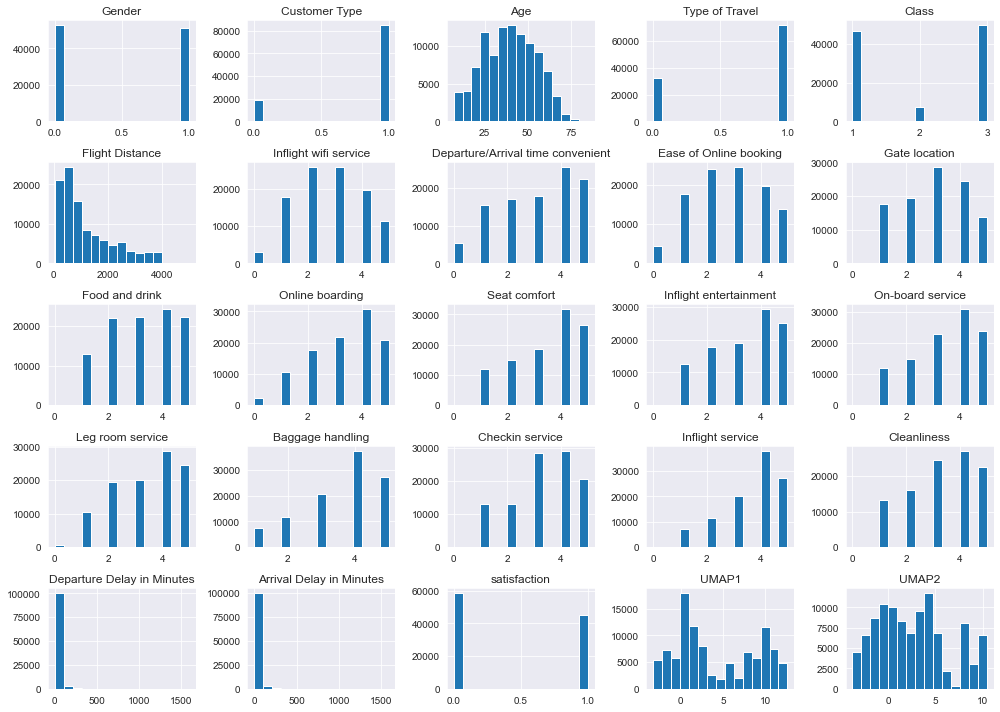

In [93]:
train_df.hist(figsize=(14,10), bins=15)
plt.tight_layout()
plt.show()

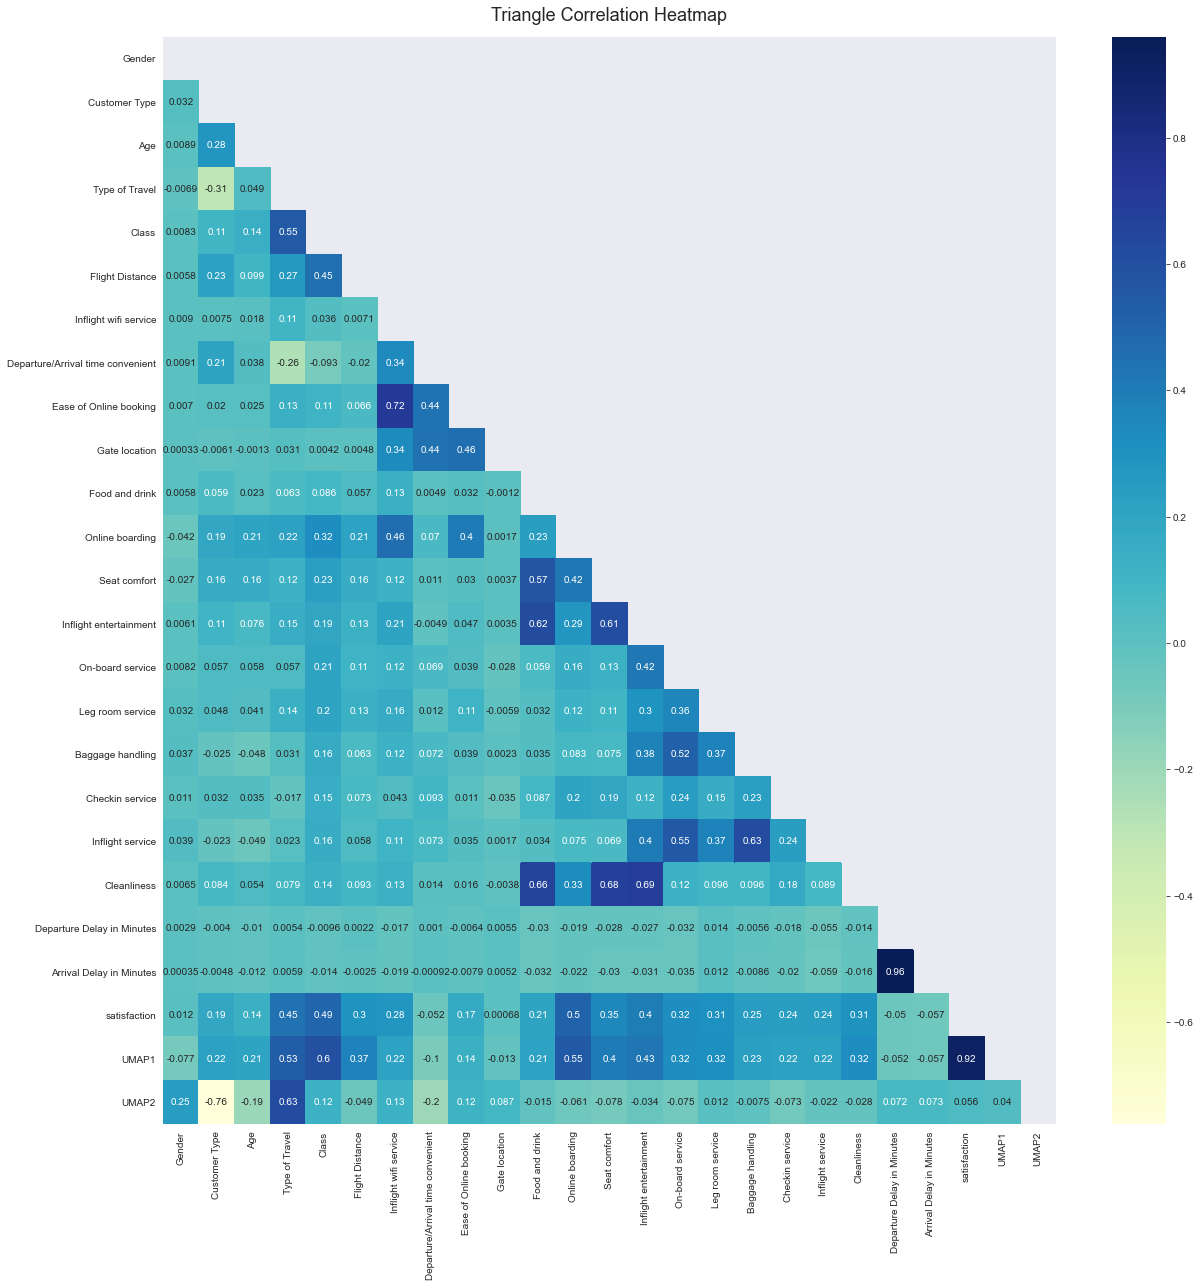

In [94]:
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(train_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_df.corr(), annot=True, mask=mask, cmap="YlGnBu")
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()

We could drop one of the delay columns, likely arrival delay, since they both are alike in definition and highly collinear. Some other attributes have some correlation. However, they measure completely differnet aspects of a flight experience among all other attributes so I will leave them alone.

Also, Flight Distance is positively skewed, so we could correct it with log transformation.

In [95]:
train_df['Flight Distance'] = train_df['Flight Distance'].apply(np.log1p)
test_df['Flight Distance'] = test_df['Flight Distance'].apply(np.log1p)

In [96]:
train_df.drop(columns=['Arrival Delay in Minutes'], inplace=True)
test_df.drop(columns=['Arrival Delay in Minutes'], inplace=True)

Now let's split our data into training and testing sets:

In [97]:
#Reorder columns for train and test splits:
new_col_order = train_df.columns.tolist()[:-3] + ['UMAP1', 'UMAP2']

In [100]:
#Creating train test splits from the data
X_train, y_train = train_df.loc[:, new_col_order], train_df['satisfaction']
X_test, y_test = test_df.loc[:, new_col_order], test_df['satisfaction']

In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We may want to manually split the data ourselves and ensure we have balanced target distributions. So I will include the following to use in the case we manually create data splits for training and testing.

In [144]:
all_df = pd.concat([train_df, test_df], axis=0)
all_df.reset_index(drop=True, inplace=True)

In [147]:
all_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,UMAP1,UMAP2
0,1,1,13,0,2,6.133398,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,0,-2.956450,0.900261
1,1,0,25,1,3,5.463832,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,0,1.186530,8.724575
2,0,1,26,1,3,7.041412,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,1,9.965812,0.051940
3,0,1,25,1,3,6.333280,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,0,1.654054,3.140802
4,1,1,61,1,3,5.370638,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,1,10.599941,4.779092


In [148]:
new_col_order = all_df.columns.tolist()[:-3] + ['UMAP1', 'UMAP2']

In [149]:
X = all_df.loc[:, new_col_order]
y = all_df.loc[:, 'satisfaction']

In [152]:
#I manually split the data for the purpose of assuring we have equal distributions of our target being the column 'satisfied'

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.20, stratify=y)

In [153]:
#Scaling the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression (Baseline/Benchmark Run)
I'll first apply a standard Logistic Regression classifier and see what results we obtain.

In [154]:
lg = LogisticRegression(random_state=3, max_iter=1000, n_jobs=-1)

In [155]:
lg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=3)

In [156]:
print(f"Baseline Logistic Regression score: {lg.score(X_test_scaled, y_test)}")

Baseline Logistic Regression score: 0.9842546966430551


Using the UMAP components I believed have enhanced what this metric would have been without them. We already obtain an accuracy into the 90s which is great. However, let's investigate further our attributes and their signifiance in the model as well as other factors in the model results.

Let's create a statsmodels Logit model and examine the results.

### Logit Model

In [158]:
X_sm = sm.add_constant(X_train)

In [159]:
logit_model = sm.Logit(y_train, X_sm).fit()

Optimization terminated successfully.
         Current function value: 0.076597
         Iterations 10


In [160]:
logit_model.summary() #max likelihood estimation

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103880
Method:                           MLE   Df Model:                           23
Date:                Sun, 05 Jun 2022   Pseudo R-squ.:                  0.8881
Time:                        20:33:50   Log-Likelihood:                -7958.7
converged:                       True   LL-Null:                       -71126.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1160      0.261    -11.931      0.000      -3.628      -2.604
Gender                                1.3252      0.056     23.599      0.000       1.215       1.435
Customer Type                         0.8846      0.115      7.702      0.000       0.659       1.110
Age                                  -0.0393      0.002    -21.744      0.000      -0.043      -0.036
Type of Travel                       -1.8256      0.098    -18.593      0.000      -2.018      -1.633
Class                                -0.6932      0.033    -21.140      0.000      -0.757      -0.629
Flight Distance                      -0.1690      0.029     -5.749      0.000      -0.227      -0.111
Inflight wifi service                 0.1506      0.031      4.806      0.000       0.089       0.212
Departure/Arrival time convenient    -0.0505      0.017     -2.965      0.003      -0.084      -0.017
Ease of Online booking                0.0350      0.029      1.193      0.233      -0.022       0.092
Gate location                        -0.0722      0.019     -3.719      0.000      -0.110      -0.034
Food and drink                       -0.0181      0.026     -0.688      0.492      -0.070       0.033
Online boarding                      -0.2464      0.025     -9.970      0.000      -0.295      -0.198
Seat comfort                         -0.1085      0.025     -4.280      0.000      -0.158      -0.059
Inflight entertainment               -0.0341      0.033     -1.037      0.300      -0.099       0.030
On-board service                      0.0796      0.024      3.265      0.001       0.032       0.127
Leg room service                      0.0209      0.019      1.074      0.283      -0.017       0.059
Baggage handling                      0.0885      0.027      3.299      0.001       0.036       0.141
Checkin service                       0.1131      0.020      5.532      0.000       0.073       0.153
Inflight service                      0.1150      0.029      3.901      0.000       0.057       0.173
Cleanliness                          -0.0456      0.029     -1.576      0.115      -0.102       0.011
Departure Delay in Minutes           -0.0042      0.001     -6.341      0.000      -0.005      -0.003
UMAP1                                 1.5505      0.015    102.803      0.000       1.521       1.580
UMAP2                                 0.2794      0.016     17.231      0.000       0.248       0.311
=====================================================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

We get a LLR p-value of 0.0, so we know our model is significant. Though, according to the summary table, many of the variables are not significant to the model. We can try to drop them and run the same model without any of the attributes with high p-values.

In [161]:
low_pvalue_cols = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Gate location', 'Online boarding', 'Seat comfort', 'On-board service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Departure Delay in Minutes', 'UMAP1', 'UMAP2']


In [162]:
X_sm = sm.add_constant(X_train[low_pvalue_cols])
logit_model = sm.Logit(y_train, X_sm).fit()

Optimization terminated successfully.
         Current function value: 0.076675
         Iterations 10


In [163]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103885
Method:                           MLE   Df Model:                           18
Date:                Sun, 05 Jun 2022   Pseudo R-squ.:                  0.8880
Time:                        20:36:18   Log-Likelihood:                -7966.8
converged:                       True   LL-Null:                       -71126.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.2005      0.250    -12.789      0.000      -3.691      -2.710
Gender                                1.3171      0.056     23.508      0.000       1.207       1.427
Customer Type                         0.8957      0.115      7.808      0.000       0.671       1.121
Age                                  -0.0390      0.002    -21.676      0.000      -0.042      -0.035
Type of Travel                       -1.8461      0.096    -19.181      0.000      -2.035      -1.657
Class                                -0.6760      0.032    -21.014      0.000      -0.739      -0.613
Flight Distance                      -0.1638      0.029     -5.595      0.000      -0.221      -0.106
Inflight wifi service                 0.1790      0.022      8.219      0.000       0.136       0.222
Departure/Arrival time convenient    -0.0458      0.016     -2.779      0.005      -0.078      -0.014
Gate location                        -0.0673      0.019     -3.556      0.000      -0.104      -0.030
Online boarding                      -0.2437      0.023    -10.428      0.000      -0.289      -0.198
Seat comfort                         -0.1701      0.019     -9.113      0.000      -0.207      -0.133
On-board service                      0.0747      0.023      3.206      0.001       0.029       0.120
Baggage handling                      0.0842      0.026      3.199      0.001       0.033       0.136
Checkin service                       0.1180      0.020      5.945      0.000       0.079       0.157
Inflight service                      0.1075      0.028      3.873      0.000       0.053       0.162
Departure Delay in Minutes           -0.0042      0.001     -6.481      0.000      -0.006      -0.003
UMAP1                                 1.5482      0.015    103.433      0.000       1.519       1.578
UMAP2                                 0.2816      0.016     17.529      0.000       0.250       0.313
=====================================================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

We obtain a little greater log likelihood value and that appears to be the biggest difference. Let's try some other models and inspect their confusion matrices as well as make ROC curves.

## Logistic Regression
This section in particular will handle building a optimized set of hyperparameters for Logistic Regression.

In [167]:
#Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=3, n_jobs=-1, C=0.1, solver='liblinear', penalty='l2')
log_reg.fit(X_train_scaled, y_train)
print(f"Logistic Regression score: {lg.score(X_test_scaled, y_test)}")

Logistic Regression score: 0.9842546966430551


In [168]:
#Saving ROC AUC results
y_pred_proba = log_reg.predict_proba(X_test_scaled)[::,1]
lr_fpr, lr_tpr, _ = roc_curve(y_test,  y_pred_proba)

lr_auc = roc_auc_score(y_test, y_pred_proba)

In [173]:
y_pred = log_reg.predict(X_test_scaled)
print(f"Logistic Regression f1 Score: {f1_score(y_test, y_pred, average='binary')}")

Logistic Regression f1 Score: 0.9818408959086244


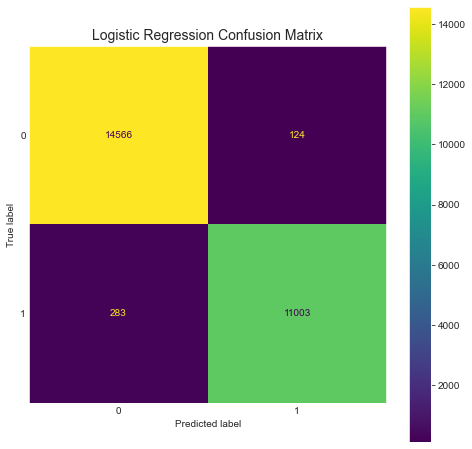

In [169]:
#Displaying confusion matrix
y_preds = log_reg.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_preds, labels=log_reg.classes_)


cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_reg.classes_)

fig, ax = plt.subplots(figsize=(8,8))
cm_disp.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Logistic Regression Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()


With a few different trials, this is the best model we can achieve with Logistic Regression. We obtain more false negatives with this model, so we misclassify more dissatisfied records that we do satisfied records.

## KNN

In [188]:
knn = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)
knn.fit(X_train_scaled, y_train)
print(f"KNN score: {knn.score(X_test_scaled, y_test)}")

KNN score: 0.9674699722821065


In [189]:
#Saving ROC AUC results
y_pred_proba = knn.predict_proba(X_test_scaled)[::,1]
knn_fpr, knn_tpr, _ = roc_curve(y_test,  y_pred_proba)

knn_auc = roc_auc_score(y_test, y_pred_proba)

In [190]:
y_pred = knn.predict(X_test_scaled)
print(f"KNN f1 Score: {f1_score(y_test, y_pred, average='binary')}")

KNN f1 Score: 0.9616901663870879


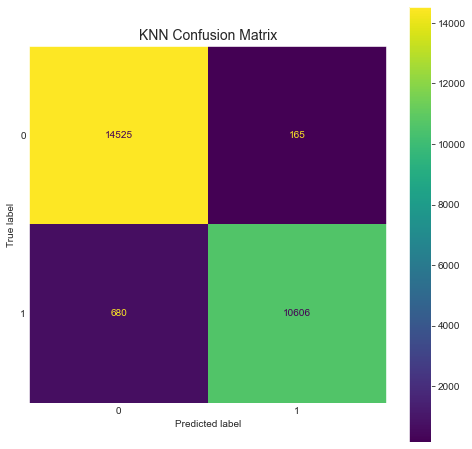

In [191]:
#Displaying confusion matrix
y_preds = knn.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_preds, labels=knn.classes_)


cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn.classes_)

fig, ax = plt.subplots(figsize=(8,8))
cm_disp.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('KNN Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

It appears our Logistic Regression model is still our best model thus far. KNN misclassifies more of the dissatisfied records. Even with a larger value of neighbors above the default, we still get a very high accuracy with this model, despite having a fairly large dataset.

## Support Vector Machine

In [196]:
#svc
svc = SVC(C=0.5, random_state=3, kernel='rbf', max_iter=1000, probability=True)
svc.fit(X_train_scaled, y_train)
print(f"SVC score: {svc.score(X_test_scaled, y_test)}")

SVC score: 0.9121496766245766


In [197]:
#Saving ROC AUC results
y_pred_proba = svc.predict_proba(X_test_scaled)[::,1]
svc_fpr, svc_tpr, _ = roc_curve(y_test,  y_pred_proba)

svc_auc = roc_auc_score(y_test, y_pred_proba)

In [198]:
y_pred = svc.predict(X_test_scaled)
print(f"SVC f1 Score: {f1_score(y_test, y_pred, average='binary')}")

SVC f1 Score: 0.9076262953367875


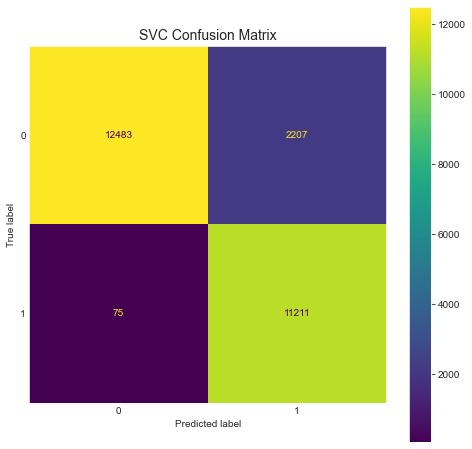

In [199]:
#Displaying confusion matrix
y_preds = svc.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_preds, labels=svc.classes_)


cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc.classes_)

fig, ax = plt.subplots(figsize=(8,8))
cm_disp.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('SVC Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

The SVC doesn't classify the dissatisfied records well and overshoots them with satisfied predictions, giving us more false positives here. Since we have a fairly large dataset and does take more time to train. We obtain a much better f1 score with the 'rbf' kernel, which fits in line with the nature of our data.

We correctly predict more satisfied records, but not as many dissatisfied records.

## Random Forest Classifier

In [205]:
rf = RandomForestClassifier(n_estimators=2000, n_jobs=-1, min_samples_leaf=50, max_depth=10, min_samples_split=30)
rf.fit(X_train_scaled, y_train)
print(f"Random Forest Classifier score: {rf.score(X_test_scaled, y_test)}")

Random Forest Classifier score: 0.9876809362488451


In [201]:
y_pred_proba = rf.predict_proba(X_test_scaled)[::,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test,  y_pred_proba)

rf_auc = roc_auc_score(y_test, y_pred_proba)

In [204]:
y_pred = rf.predict(X_test_scaled)
print(f"Random Forest Classifier f1 Score: {f1_score(y_test, y_pred, average='binary')}")

Random Forest Classifier f1 Score: 0.9858854860186418


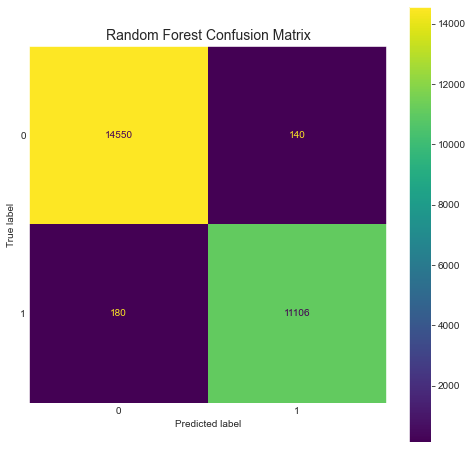

In [206]:
y_preds = rf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_preds, labels=rf.classes_)


cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)

fig, ax = plt.subplots(figsize=(8,8))
cm_disp.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Random Forest Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

Unsurprisingly, this is our best model yet. Since we have many categorical values that a tree-based model can evaluate for thresholds, this model does exceptionally well.

## AdaBoost Classifier
This algorithm formulates a strong learner from several weak learners. Does this approach work well with our data?

In [210]:
ada = AdaBoostClassifier(n_estimators=2000, learning_rate=0.1, random_state=3)
ada.fit(X_train_scaled, y_train)
print(f"AdaBoost Classifier score: {ada.score(X_test_scaled, y_test)}")

AdaBoost Classifier score: 0.9883738835848476


In [211]:
y_pred_proba = ada.predict_proba(X_test_scaled)[::,1]
ada_fpr, ada_tpr, _ = roc_curve(y_test,  y_pred_proba)

ada_auc = roc_auc_score(y_test, y_pred_proba)

In [212]:
y_pred = ada.predict(X_test_scaled)
print(f"AdaBoost Classifier f1 Score: {f1_score(y_test, y_pred, average='binary')}")

AdaBoost Classifier f1 Score: 0.9865932699991121


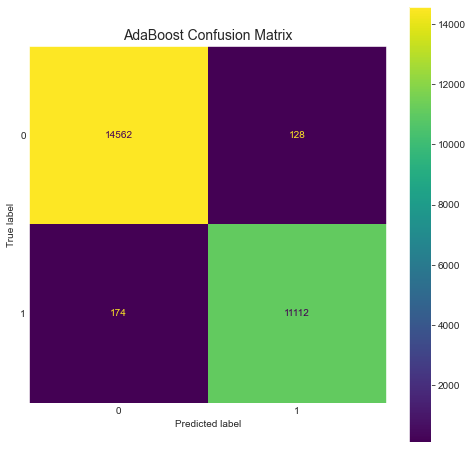

In [214]:
y_preds = ada.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_preds, labels=ada.classes_)


cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=ada.classes_)

fig, ax = plt.subplots(figsize=(8,8))
cm_disp.plot(ax=ax)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title('AdaBoost Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

We get a small improvement with this algorithm over the Random Forest classifier. Weights become larger if the classifier is more accurate.

## ROC AUC Curve
Let's now compare our models to see which one is more consistent among them using the ROC AUC cruve. The model with the greatest AUC is considered the 'best' model.

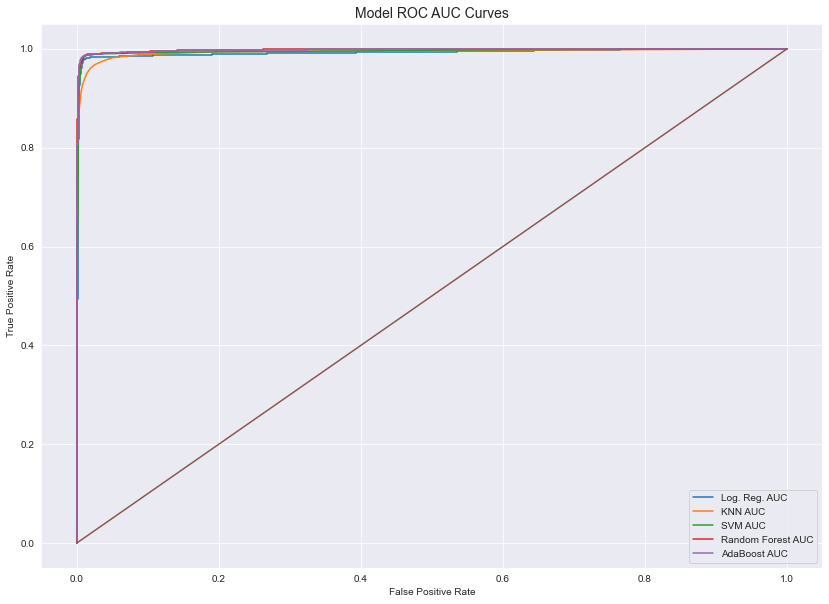

In [228]:
plt.figure(figsize=(14,10))
plt.plot(lr_fpr, lr_tpr, label="Log. Reg. AUC")
plt.plot(knn_fpr, knn_tpr, label="KNN AUC")
plt.plot(svc_fpr, svc_tpr, label="SVM AUC")
plt.plot(rf_fpr, rf_tpr, label="Random Forest AUC")
plt.plot(ada_fpr, ada_tpr, label="AdaBoost AUC")

plt.title("Model ROC AUC Curves", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot([0,1])
plt.legend()
plt.show()

According to our ROC AUC curve graph, we obtain near perfect models using Random Forest and AdaBoost classifiers. Generating the UMAP components I believe greatly enhanced catpruing the activity of the data in relation to the target variable. Using the Logit model also confirmed they were very significant to the model with p-values of 0.

## Closing Remarks:
* After manually splitting the data combining both datasets and ensuring the target <i>satisfaction</i> is balanced (with stratification), we obtain models with very strong predictive power.


* We applied a few different algorithms, at first Logistic Regression performed very well as it can classify binary labels very well. Following this, it wasn't surprising the tree-based models outperformed the other models as we have many categorical variables for which tree-based models can split data on efficiently.


* Using the Logit model we were able to look at signifiance of individual attributes. Aspects of flights such as <i>Food and drink, Ease of online booking, Inflight entertainment</i> are streamlined on most flights, with small differences between Economy and Business classes. Therefore, I could understand how these attributes weren't necessarily significant to that model.

This concludes the classification model building of this project. Since we already achieve such high performance metrics, I don't think it would be necessary to create a deep learning model in this case.